***CRYPTO PRICES END-to-END ETL PIPELINE***

---

AUTHOR: [`STEPHEN ADEGBILE`](https://stephenadegbile.uk/)

In [ ]:
pip install google-cloud-bigquery pandas matplotlib seaborn


In [2]:
from google.cloud import bigquery
from google.oauth2 import service_account

# Path to the uploaded file
credentials = service_account.Credentials.from_service_account_file(
    'crypto-data-engineering-c2e6964cc086.json'
)

client = bigquery.Client(
    project="crypto-data-engineering",
    credentials=credentials
)

***Query for raw data***

In [32]:
import pandas as pd

sql_raw = """
SELECT *
FROM `crypto-data-engineering.crypto.raw_prices`
ORDER BY ingested_at DESC
LIMIT 50
"""

df_raw = client.query(sql_raw).to_dataframe()
df_raw.head()


,symbol,price,event_ts,payload,ingested_at
0,WRAPPED-BITCOIN,86773.000000,2025-12-02 05:40:03.488424+00:00,"{""usd"": 86773}",2025-12-02 05:40:15.082741+00:00
1,CARDANO,0.390834,2025-12-02 05:40:03.488424+00:00,"{""usd"": 0.390834}",2025-12-02 05:40:15.082741+00:00
2,ETHEREUM,2799.820000,2025-12-02 05:40:03.488424+00:00,"{""usd"": 2799.82}",2025-12-02 05:40:15.082741+00:00
3,USD-COIN,0.999770,2025-12-02 05:40:03.488424+00:00,"{""usd"": 0.99977}",2025-12-02 05:40:15.082741+00:00
4,BINANCE-BRIDGED-USDT-BNB-SMART-CHAIN,0.999815,2025-12-02 05:40:03.488424+00:00,"{""usd"": 0.999815}",2025-12-02 05:40:15.082741+00:00


***Query for clean data***

In [41]:
sql_clean = """
SELECT *
FROM `crypto-data-engineering.crypto.prices_hourly`
ORDER BY price_ts DESC
LIMIT 50
"""

df_clean = client.query(sql_clean).to_dataframe()
df_clean.head()


,symbol,price,price_ts,price_date,price_hour,source
0,DOGECOIN,0.135876,2025-12-02 05:55:02.884918+00:00,2025-12-02,5,coingecko
1,TRON,0.277028,2025-12-02 05:55:02.884918+00:00,2025-12-02,5,coingecko
2,WRAPPED-BEACON-ETH,3033.210000,2025-12-02 05:55:02.884918+00:00,2025-12-02,5,coingecko
3,FIGURE-HELOC,1.031000,2025-12-02 05:55:02.884918+00:00,2025-12-02,5,coingecko
4,TETHER,1.000000,2025-12-02 05:55:02.884918+00:00,2025-12-02,5,coingecko


***Exploratory Data Analysis***

In [43]:
missing = client.query("""
SELECT COUNT(*) AS null_count
FROM `crypto-data-engineering.crypto.prices_hourly`
WHERE price IS NULL
""").to_dataframe()
print(missing)


   null_count
0           0


In [45]:
sql_avg = """
SELECT
    symbol,
    EXTRACT(HOUR FROM price_ts) AS hour,
    AVG(price) AS avg_price,
    MIN(price) AS min_price,
    MAX(price) AS max_price
FROM `crypto-data-engineering..crypto.prices_hourly`
WHERE price_ts >= TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 24 HOUR)
GROUP BY symbol, hour
ORDER BY symbol, hour
"""

df_avg = client.query(sql_avg).to_dataframe()
df_avg.head()


,symbol,hour,avg_price,min_price,max_price
0,BINANCE-BRIDGED-USDT-BNB-SMART-CHAIN,4,1.000000,1.000000,1.000000
1,BINANCE-BRIDGED-USDT-BNB-SMART-CHAIN,5,0.999768,0.999274,1.000000
2,BINANCE-BRIDGED-USDT-BNB-SMART-CHAIN,6,0.999849,0.999849,0.999849
3,BINANCECOIN,4,832.190000,832.190000,832.190000
4,BINANCECOIN,5,830.683846,828.950000,832.740000


***Data Visualisation***

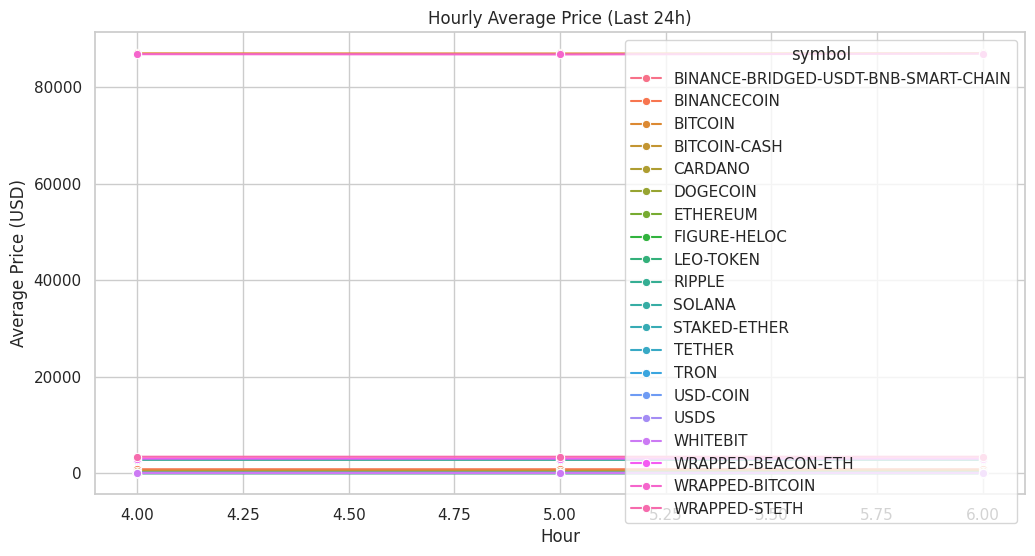

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(12,6))
sns.lineplot(data=df_avg, x="hour", y="avg_price", hue="symbol", marker="o")
plt.title("Hourly Average Price (Last 24h)")
plt.xlabel("Hour")
plt.ylabel("Average Price (USD)")
plt.show()
